In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm):

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()

In [86]:
import pandas as pd
df = pd.read_csv("heart_2022_encoded.csv")
df.head(5)

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,0,3,4,0,3,1,9,0,0,0,...,1.60,71.67,27.99,0,0,1,1,3,0,0
1,1,3,0,0,3,1,6,0,0,0,...,1.78,95.25,30.13,0,0,1,1,1,0,0
2,1,3,0,0,3,0,8,2,0,0,...,1.85,108.86,31.66,1,0,0,1,0,0,2
3,0,1,5,0,3,1,9,0,0,0,...,1.70,90.72,31.32,0,0,1,1,0,0,2
4,0,2,3,15,3,1,5,1,0,0,...,1.55,79.38,33.07,0,0,1,1,0,0,0


In [87]:
df = df.apply(lambda x: x.astype('category') if x.dtype == 'object' else x)
X = df.drop("HadHeartAttack", axis=1) 
y = df["HadHeartAttack"]

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [89]:
import lightgbm as lgb

model = lgb.LGBMClassifier(class_weight="balanced")
model.fit(X_train, y_train)


LGBMClassifier(class_weight='balanced')

In [90]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)


In [91]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.83      0.90     46573
           1       0.20      0.78      0.32      2632

    accuracy                           0.82     49205
   macro avg       0.59      0.80      0.61     49205
weighted avg       0.94      0.82      0.87     49205



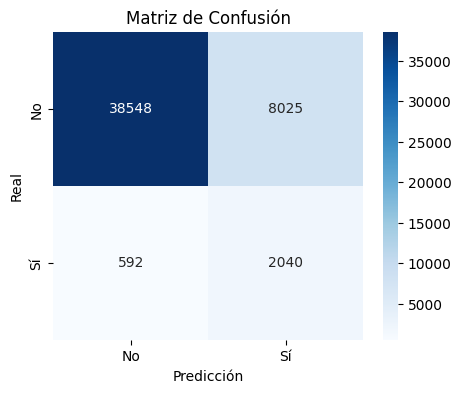

In [92]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

In [ ]:
from sklearn.metrics import fbeta_score
from imblearn.over_sampling import SMOTE

def objective(trial):
    smote = SMOTE(
        random_state=42, 
        sampling_strategy=trial.suggest_float('sampling_strategy', 0.3, 0.9), 
        k_neighbors=trial.suggest_int('k_neighbors', 3, 10), 
    )

    X_res, y_res = smote.fit_resample(X_train, y_train)

    model = lgb.LGBMClassifier(
        random_state=42,
        verbose=-1,
        boosting_type='gbdt',
        objective='binary',
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        num_leaves=trial.suggest_int('num_leaves', 20, 150),
        max_depth=trial.suggest_int('max_depth', 4, 20),
        feature_fraction=trial.suggest_float('feature_fraction', 0.6, 1.0),
        bagging_fraction=trial.suggest_float('bagging_fraction', 0.5, 1.0),
        bagging_freq=trial.suggest_int('bagging_freq', 1, 7),
        n_estimators=trial.suggest_int('n_estimators', 100, 1000),
    )

    model.fit(
        X_res, y_res,
        eval_set=[(X_test, y_test)],
        eval_metric='f1',
        callbacks=[lgb.early_stopping(stopping_rounds=30)]
    )

    y_pred = model.predict(X_test)
    fb = fbeta_score(y_test, y_pred, beta=2, pos_label=1)

    return fb



In [ ]:
import optuna

study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=200) 

In [ ]:
import json

params = study.best_params


with open('hyperparameters.json', 'w') as f:
    json.dump(params, f, indent=4)

In [ ]:
with open('hyperparameters.json', 'r') as f:
    params = json.load(f)


smote = SMOTE(
    random_state=42, 
    sampling_strategy=params['sampling_strategy'],
    k_neighbors=params['k_neighbors'],
)

X_res, y_res = smote.fit_resample(X_train, y_train)

model = lgb.LGBMClassifier(
    boosting_type='gbdt',
    random_state=42,
    objective='binary',
    metric='auc',
    learning_rate=params['learning_rate'],
    num_leaves=params['num_leaves'],
    max_depth=params['max_depth'],
    feature_fraction=params['feature_fraction'],
    bagging_fraction=params['bagging_fraction'],
    bagging_freq=params['bagging_freq'],
    n_estimators=params['n_estimators'],
)

model.fit(X_res, y_res)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

/home/paravel/dev/cardio-model/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


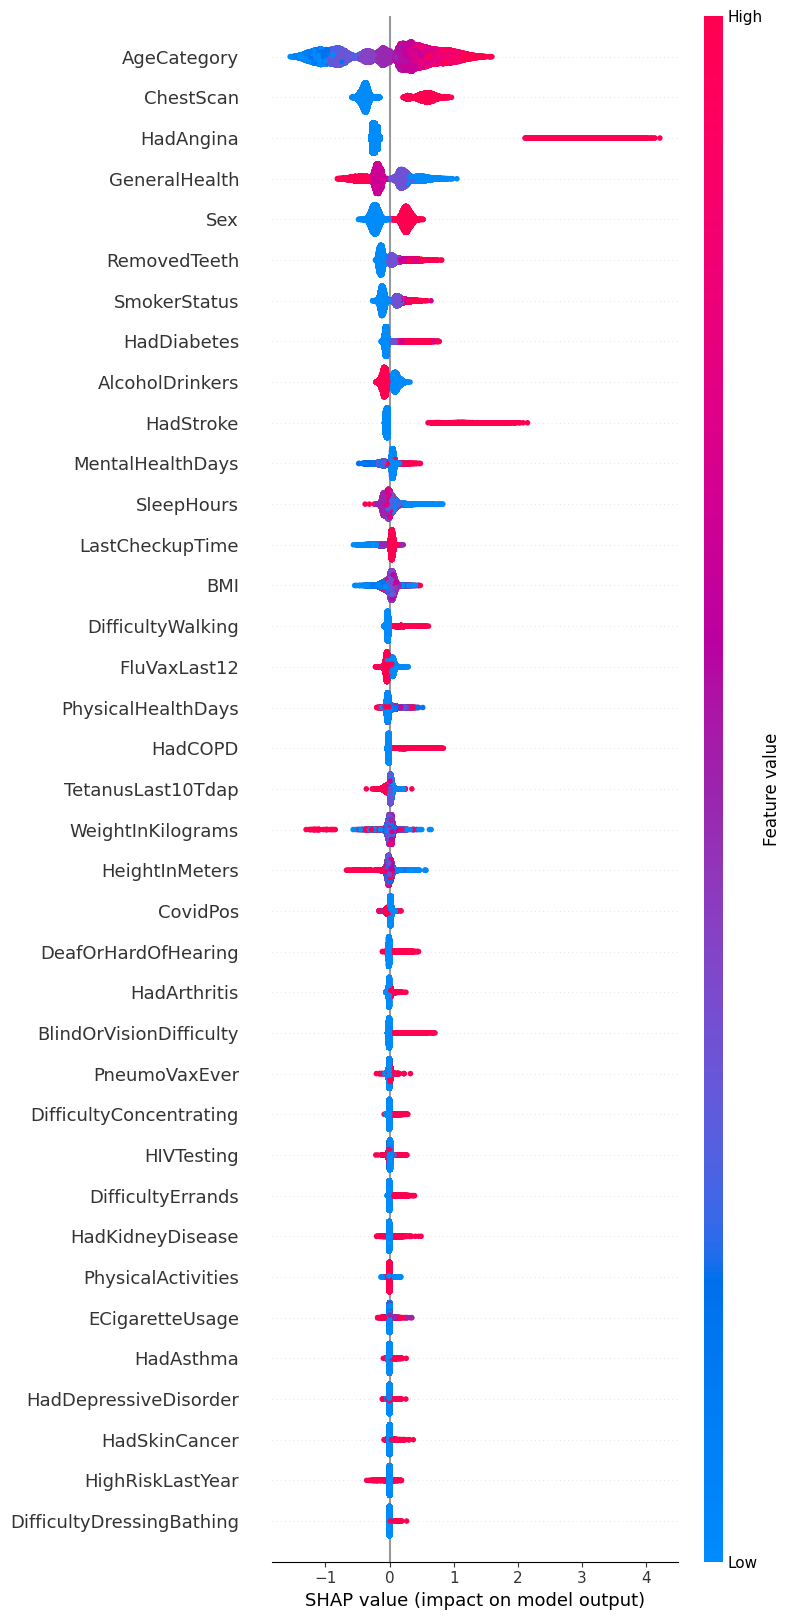

In [95]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
num_features = X_test.shape[1]
shap.summary_plot(shap_values, X_test, max_display=num_features)


In [100]:
import numpy as np
# Calcular la importancia promedio de cada característica
shap_importance = np.abs(shap_values).mean(axis=0)

# Crear un DataFrame con las características y su importancia
shap_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': shap_importance
})

shap_importance_df = shap_importance_df.sort_values(by='importance', ascending=False)
top_20_features = shap_importance_df['feature'].head(20).tolist()
shap_importance_df.head(20)

,feature,importance
26,AgeCategory,0.623701
25,ChestScan,0.458897
8,HadAngina,0.386663
1,GeneralHealth,0.284005
0,Sex,0.245294
7,RemovedTeeth,0.138418
23,SmokerStatus,0.135727
16,HadDiabetes,0.100480
30,AlcoholDrinkers,0.098582
9,HadStroke,0.088166


In [101]:
# Filtrar los conjuntos de datos
X_train_top20 = X_train[top_20_features]
X_test_top20 = X_test[top_20_features]

In [ ]:
# Crear y entrenar el modelo
model_top20 = lgb.LGBMClassifier(class_weight="balanced")
model_top20.fit(X_train_top20, y_train)